In [49]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import json
import pickle
import gzip
import networkx as nx
from tqdm import tqdm
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs

from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.test_dataset_background import TestDataset as TestDatasetBackground
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.crp_attribution import CRPAttribution
from expbasics.network import load_model, train_network, accuracy_per_class
from measures0_to_2_new import AllMeasures
import collections.abc
from expbasics.background_dataset import BackgroundDataset
from expbasics.visualizations import data_iterations, my_plot_grid

%reload_ext autoreload
%autoreload 2
plt.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.family': 'serif', "font.size": 14})
torch.set_grad_enabled(False) 

In [50]:
ALL_MEASURES = [
    "m1_phi",
    "m1_mlc_abs",
    "m1_mlc_cosine",
    "m1_mlc_euclid",
    "m1_mlc_l2square",
    "m2_rel_abs",
    "m2_rel_cosine",
    "m2_rel_euclid",
    "m2_rel_l2square",
    "m2_mac_abs",
    "m2_mac_euclid",
    "m2_mac_cosine",
    "m2_mac_l2square",
    "m2_rma",
    "m2_rma_unweighted",
    "m2_pg_weighted",
    "m2_pg_unweighted",
    "m2_rra_weighted",
    "m2_rra_unweighted",
    "m2_Rel_max_diff",
    "m2_Rel_max_m_rels",
    "m2_Rel_max_stats",
    "m2_Rel_max_stats_diff",
    "m2_Act_max_diff",
    "m2_Act_max_m_rels",
    "m2_Act_max_stats",
    "m2_Act_max_stats_diff",
    "m2_Rel_sum_diff",
    "m2_Rel_sum_m_rels",
    "m2_Rel_sum_stats",
    "m2_Rel_sum_stats_diff",
    "m2_Act_sum_diff",
    "m2_Act_sum_m_rels",
    "m2_Act_sum_stats",
    "m2_Act_sum_stats_diff",
]

NAME_DICT = {
    "m1_phi": "$m_1$: Prediction Flip",
    "m1_mlc_abs": "$m_1$: Output Logits Absolute Distance",
    "m1_mlc_cosine": "$m_1$: Output Logits Cosine Distance",
    "m1_mlc_euclid": "$m_1$: Output Logits Euclidean Distance (= Absolute Distance) ",
    "m1_mlc_l2square": "$m_1$: Output Logits Squared ",
    "m2_rel_abs": "$m_2$: Relevance Vector Absolute Distance",
    "m2_rel_cosine": "$m_2$: Relevance Vector Cosine Distance",
    "m2_rel_euclid": "$m_2$: Relevance Vector Euclidean",
    "m2_rel_l2square": "$m_2$: Relevance Vector Squared Distance",
    "m2_mac_abs": "$m_2$: Attribution Maps Absolute Distance",
    "m2_mac_euclid": "$m_2$: Attribution Maps Euclidean",
    "m2_mac_cosine": "$m_2$: Attribution Maps Cosine Distance",
    "m2_mac_l2square": "$m_2$: Attribution Maps Squared Distance",
    "m2_rma": "$m_2$: RMA Relative Relevance in $B$ weighted",
    "m2_rma_unweighted": "$m_2$: RMA Relative Relevance in $B$",
    "m2_pg_weighted": "$m_2$: Pointing Game weighted",
    "m2_pg_unweighted": "$m_2$: Pointing Game",
    "m2_rra_weighted": "$m_2$: RRA weighted",
    "m2_rra_unweighted": "$m_2$: RRA",
    "m2_Rel_max_diff": "$m_2$: relevance, t=max, diff",
    "m2_Rel_max_m_rels": "$m_2$: relevance, t=max, m_rels",
    "m2_Rel_max_stats": "$m_2$: relevance, t=max, stats",
    "m2_Rel_max_stats_diff": "$m_2$: relevance, t=max, stats_diff",
    "m2_Act_max_diff": "$m_2$: activation, t=max, diff",
    "m2_Act_max_m_rels": "$m_2$: activation, t=max, m_rels",
    "m2_Act_max_stats": "$m_2$: activation, t=max, stats",
    "m2_Act_max_stats_diff": "$m_2$: activation, t=max, stats_diff",
    "m2_Rel_sum_diff": "$m_2$: relevance, t=sum, diff",
    "m2_Rel_sum_m_rels": "$m_2$: relevance, t=sum, m_rels",
    "m2_Rel_sum_stats": "$m_2$: relevance, t=sum, stats",
    "m2_Rel_sum_stats_diff": "$m_2$: relevance, t=sum, stats_diff",
    "m2_Act_sum_diff": "$m_2$: activation, t=sum, diff",
    "m2_Act_sum_m_rels": "$m_2$: activation, t=sum, m_rels",
    "m2_Act_sum_stats": "$m_2$: activation, t=sum, stats",
    "m2_Act_sum_stats_diff": "$m_2$: activation, t=sum, stats_diff",
}
ms = AllMeasures(
    "../dsprites-dataset/images/",
)

#{a: NAME_DICT[a] if a in NAME_DICT else a for a in ALL_MEASURES}

In [231]:
# Load All Measures
EXPERIMENT = 2


if EXPERIMENT == 1:
    # Experiment 1:
    model_path = "../clustermodels/final"
    experiment_name = "attribution_output"
    sample_set_size = 128
    layer_name = "convolutional_layers.6"
    is_random = False
    model_type = "watermark"
    iterations = 16
    datasettype = BiasedNoisyDataset
    mask = "bounding_box"
    accuracypath = "outputs/retrain.json"
    relsetds = TestDataset(length=300, im_dir="watermark_test_data")
else:
    # Experiment 2:
    model_path = "../clustermodels/background"
    experiment_name = "overlap_attribution"
    sample_set_size = 128
    layer_name = "convolutional_layers.6"
    is_random = False
    model_type = "overlap"
    iterations = 10
    datasettype = BackgroundDataset
    mask = "shape"
    accuracypath = "outputs/overlap1.json"
    relsetds = TestDatasetBackground(length=300, im_dir="overlap_test_data")


ms = AllMeasures(
    "../dsprites-dataset/images/",
    sample_set_size,
    layer_name,
    model_path,
    experiment_name,
)

with gzip.open(f"all_measures_{sample_set_size}_{experiment_name}.pickle", "rb") as f:
    per_sample = pickle.load(f)

with gzip.open(
    f"relmax_measures_{sample_set_size}_{experiment_name}.pickle", "rb"
) as f:
    rel_max_m = pickle.load(f)

perseed_all = torch.zeros(51, iterations, per_sample.shape[3] + rel_max_m.shape[2])
perseed_all[:, :, : per_sample.shape[3]] = per_sample.mean(dim=2)
perseed_all[:, :, per_sample.shape[3] :] = rel_max_m
perseed_all.requires_grad = False
""" perseed_some = perseed_all[:,:10,:]
iterations = 10 """
rel_max_m.shape, per_sample.shape, perseed_all.shape

BIASES = list(np.round(np.linspace(0, 1, 51), 3))  # [0,0.5,0.9, 1.0]#

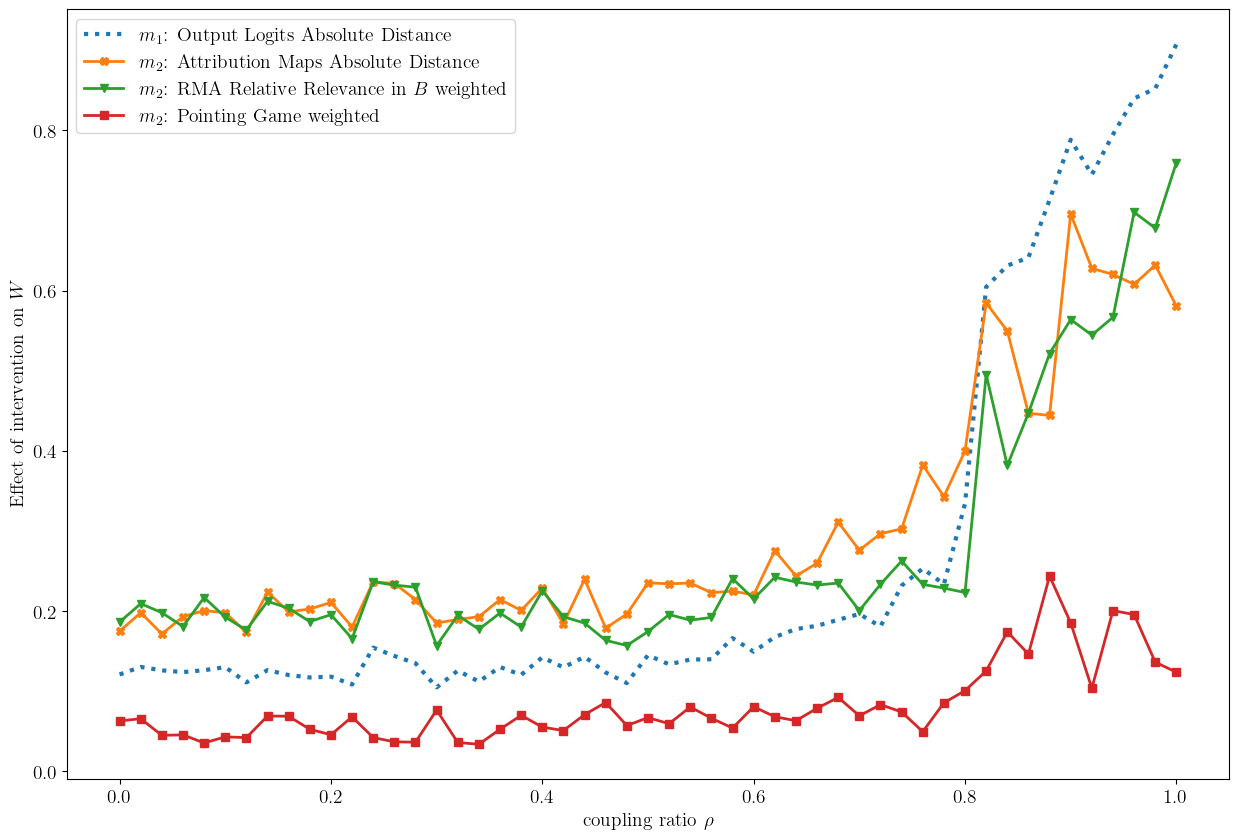

In [233]:
# SHOW CERTAIN MEASURES
markerstyles = [
    "d",
    "X",
    "v",
    "s",
    "^",
    "P",
    "<",
    "*",
    ">",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
]


def draw_measures(perseed_all, ptype="all", with_title=False):
    variable_options = {
        # "m0": [range(0,3), "data distribution for only 128 samples $m_0$", "correlation", -0.14,3],
        "m1": [
            [0, 1, 2, 3, 4],
            "Ground Truth Model Importance $m_1$",
            "model importance $m_1$",
            -0.18,
            3,
        ],
        "m2": [
            range(5, 17),
            "Mean Attribution Change (comparing distance metrics) $m_2$",
            "MAC $m_2$",
            -0.33,
            3,
        ],
        "m2_mac": [
            range(9, 13),
            "Mean Attribution Change (comparing distance metrics) $m_2$",
            "MAC $m_2$",
            -0.23,
            3,
        ],
        "m2_region": [
            range(13, 17),
            "Region specific metrics $m_2$",
            "region-specific change $m_2$",
            -0.23,
            3,
        ],
        "m2_rel": [
            [5, 6, 7, 8],
            "Relevance Vector (comparing distance metrics) $m_2$",
            "relevance vector change $m_2$",
            -0.18,
            2,
        ],
        "abs": [
            [1, 5, 9],
            "Absolute Measures $m_2$",
            "absolute change $m_2$",
            -0.22,
            3,
        ],
        "kernel": [
            [4, 8, 12],
            "Kernelized Treatment Effect $m_2$",
            "kernelized change $m_2$",
            -0.14,
            3,
        ],
        "euclid": [
            [3, 7, 10],
            "Euclidean Distance Measures $m_2$",
            "euclidean change $m_2$",
            -0.18,
            3,
        ],
        "cosine": [
            [2, 6, 11],
            "Cosine Distance Measures $m_2$",
            "cosine change $m_2$",
            -0.14,
            4,
        ],
        "all": [
            range(len(ALL_MEASURES)),
            "All Measures $m_0,m_1,m_2$",
            "all measures",
            -0.48,
            3,
        ],
        "chosen": [
            [0, 4, 8, 12, 13, 14, 15, 16],
            "All Chosen Metrics",
            "all",
            -0.33,
            3,
        ],
    }

    if isinstance(ptype, collections.abc.Sequence) and (not isinstance(ptype, str)):
        plot_variables = [
            [ALL_MEASURES.index(n) for n in ptype],  # type: ignore
            "comparison",
            "Effect of intervention on $W$",
            -0.17 * max(len(ptype) // 3, 1),
            3,
        ]
    elif ptype in variable_options:
        plot_variables = variable_options[ptype]
    else:
        plot_variables = [
            [ALL_MEASURES.index(ptype)],
            NAME_DICT[ptype],
            "change",
            -0.14,
            1,
        ]
    biases = list(np.round(np.linspace(0, 1, 51), 3))  # [0,0.5,0.9, 1.0]#
    used_measures = plot_variables[0]
    ls = ["dashdot", "dotted", "solid"]
    colors = matplotlib.cm.tab10(  # tab10 hsv
        np.linspace(0, 1, max(len(used_measures), 10))
    )  # ["#f00", "#088"]#
    plt.figure(figsize=(15, 10))
    for en, i in enumerate(used_measures):
        l = ALL_MEASURES[i]
        label = NAME_DICT[l]
        linestyle = ls[int(l[1])]  # "solid" #
        linewidth = 3 if l == "m1_mlc_abs" else 2
        marker = markerstyles[en] if int(l[1]) > 1 else ""
        if used_measures[-1] < 4:
            marker = markerstyles[en]
            linestyle = "solid"
            linewidth = 2 if l == "m1_mlc_abs" else 1
        normed = perseed_all[:, :, i]  # / perseed_all[:, :, i].max()#.abs().sum() #
        vals = torch.abs(torch.mean(normed, dim=1))
        #
        if l == "m1_mlc_euclid":
            vals = vals * math.sqrt(2)
        """ if l == "m2_mac_euclid":
            vals = vals * 10 """
        if l == "m2_mac_l2square":
            vals = vals * (32**2)  # / perseed_all[:, :, i].max() #
        if l == "m2_mac_euclid":
            vals = vals / perseed_all[:, :, i].max()  # * (30)  #
        # vals = (vals / vals.max()) * torch.mean(perseed_all[:, :, 1], dim=1).max()
        sigma = torch.std(normed, dim=1) / math.sqrt(iterations)
        # vmin = torch.min(per_seed[:, :, i], dim=1).values
        # vmax = torch.max(per_seed[:, :, i], dim=1).values
        if l:
            plt.plot(
                biases,
                vals.detach().numpy(),
                label=label,
                linestyle=linestyle,
                c=colors[en],
                marker=marker,
                linewidth=linewidth,
            )

            """ plt.fill_between(
                biases,
                vals + sigma,
                vals - sigma,
                facecolor=colors[en],
                alpha=0.3,
            ) """
    if with_title:
        plt.title(plot_variables[1])
    plt.ylabel(plot_variables[2])
    plt.xlabel("coupling ratio $\\rho$")
    """ plt.legend(
        bbox_to_anchor=(0.0, plot_variables[3], 1.0, 0.102),
        loc="lower left",
        ncols=plot_variables[4],
        mode="expand",
        borderaxespad=0.0,
    ) """
    plt.legend(loc="upper left")


draw_measures(
    perseed_all,
    [
    #"m1_phi",
    "m1_mlc_abs",
    #"m1_mlc_cosine",
    #"m1_mlc_euclid",
    #"m1_mlc_l2square",
    #"m2_rel_abs",
    #"m2_rel_cosine",
    #"m2_rel_euclid",
    #"m2_rel_l2square",
    "m2_mac_abs",
    #"m2_mac_euclid",
    #"m2_mac_cosine",
    #"m2_mac_l2square",
    "m2_rma",
    #"m2_rma_unweighted",
    "m2_pg_weighted",
    #"m2_pg_unweighted",
    #"m2_rra_weighted",
    #"m2_rra_unweighted",
    #"m2_Rel_max_diff",
    #"m2_Rel_max_m_rels",
    #"m2_Rel_max_stats",
    #"m2_Rel_max_stats_diff",
    #"m2_Act_max_diff",
    #"m2_Act_max_m_rels",
    #"m2_Act_max_stats",
    #"m2_Act_max_stats_diff",
    #"m2_Rel_sum_diff",
    #"m2_Rel_sum_m_rels",
    #"m2_Rel_sum_stats",
    #"m2_Rel_sum_stats_diff",
    #"m2_Act_sum_diff",
    #"m2_Act_sum_m_rels",
    #"m2_Act_sum_stats",
    #"m2_Act_sum_stats_diff",
    ],
)

# works:  "m2_Rel_max_diff","m2_Act_max_diff","m2_Rel_sum_diff","m2_Act_sum_diff",
# is around 0.8 constant:  "m_rels"
# is around 1.2 constant:  "stats"
# works somehow but not much:  "m2_Rel_max_stats_diff","m2_Act_max_stats_diff", "m2_Rel_sum_stats_diff","m2_Act_sum_stats_diff",

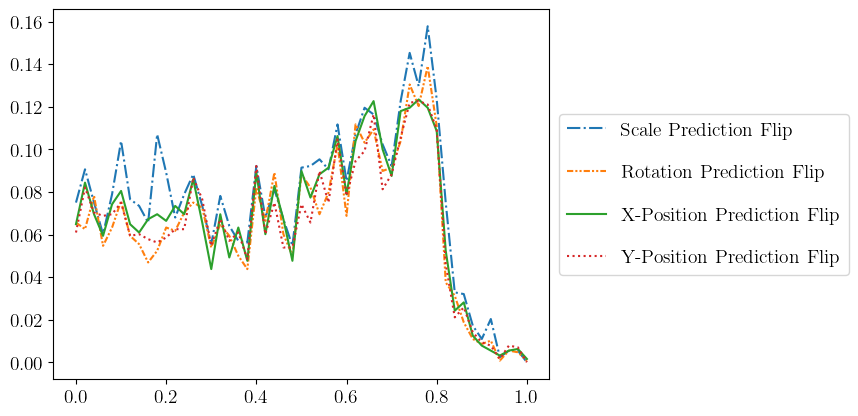

In [252]:
with gzip.open(f"latent_factors_{sample_set_size}_{experiment_name}.pickle", "rb") as f:
    latent_factors = pickle.load(f)
LF_NAMES = [
    "scale_prediction_flip",
    "scale_mlc",
    "scale_rel_change",
    "rotation_prediction_flip",
    "rotation_mlc",
    "rotation_rel_change",
    "pos_x_prediction_flip",
    "pos_x_mlc",
    "pos_x_rel_change",
    "pos_y_prediction_flip",
    "pos_y_mlc",
    "pos_y_rel_change",
]

ls = ["dashdot", "dotted", "solid", (0, (3, 1, 1, 1, 1, 1))]
usenames = [
    "scale_prediction_flip",
    # "scale_mlc",
    # "scale_rel_change",
    "rotation_prediction_flip",
    # "rotation_mlc",
    # "rotation_rel_change",
    "pos_x_prediction_flip",
    # "pos_x_mlc",
    # "pos_x_rel_change",
    "pos_y_prediction_flip",
    # "pos_y_mlc",
    # "pos_y_rel_change",
]
names_dict = {
    "scale_prediction_flip": "Scale Prediction Flip",
    "scale_mlc": "Scale Mean Logit Change",
    "scale_rel_change": "Scale Relevance Change",
    "rotation_prediction_flip": "Rotation Prediction Flip",
    "rotation_mlc": "Rotation Mean Logit Change",
    "rotation_rel_change": "Rotation Relevance Change",
    "pos_x_prediction_flip": "X-Position Prediction Flip",
    "pos_x_mlc": "X-Position Mean Logit Change",
    "pos_x_rel_change": "X-Position Relevance Change",
    "pos_y_prediction_flip": "Y-Position Prediction Flip",
    "pos_y_mlc": "Y-Position Mean Logit Change",
    "pos_y_rel_change": "Y-Position Relevance Change",
}

for l, namef in enumerate(LF_NAMES):
    if namef in usenames:
        plt.plot(
            BIASES,
            torch.mean(latent_factors[:, :, l], dim=1),
            label=names_dict[namef],
            linestyle=ls[l % 4],
        )
plt.plot(
    BIASES,
    torch.mean(perseed_all[:, :, 0], dim=1),
    label=names_dict[namef],
    linestyle=ls[l % 4],
)
plt.legend(
    bbox_to_anchor=(1, 0.5),
    loc=6,
    ncols=1,
    labelspacing=1.3,
)

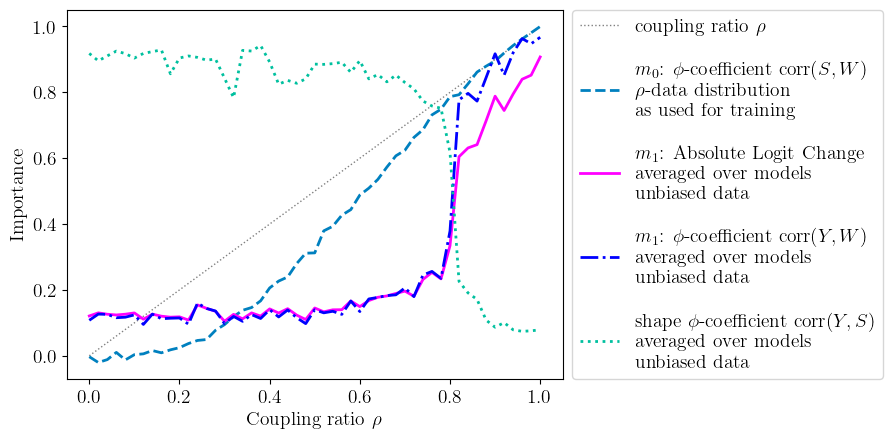

In [243]:
# Ground Truth Average

with open(f"m1_mi_6400_{experiment_name}.pickle", "rb") as f:
    m1_mi = pickle.load(f)
with open(f"m0_gt_6400_{experiment_name}.pickle", "rb") as f:  # gt_measures_1280
    gt_measures = pickle.load(f)
with open(f"shape_gt_128_{experiment_name}.pickle", "rb") as f:
    shape_gt = pickle.load(f)

with open(f"pf_128_{experiment_name}.pickle", "rb") as f:
    pf_gt = pickle.load(f)

mimean = torch.mean(
    per_sample[:, :, :, 0], dim=(1, 2)
)  # torch.mean(m1_mi[:,:,1], dim=(1))

pf_mean = torch.mean(pf_gt[:, :, 0], dim=(1))
biases = gt_measures[:, 0, 0]
#plt.figure(figsize=(10,7))

ecol = matplotlib.cm.winter(np.linspace(0, 1, 5))
scol = matplotlib.cm.spring(np.linspace(0, 1, 5))
plt.plot(
    biases,
    biases,
    linewidth=1,
    label="coupling ratio $\\rho$",
    linestyle="dotted",
    color="gray",
)
plt.plot(
    biases,
    torch.mean(gt_measures[:, :, 2], dim=1),
    linewidth=2,
    label="$m_0$: $\\phi$-coefficient corr($S,W$) \n $\\rho$-data distribution \n as used for training",
    linestyle="dashed",
    color=ecol[2],
)
plt.plot(
    biases,
    torch.mean(per_sample[:, :, :, 1], dim=(1, 2)),
    linewidth=2,
    label="$m_1$: Absolute Logit Change\n averaged over models \n unbiased data",
    #label="importance watermark (spurious feature)",
    color=scol[0],#"#C8D672"#
)
plt.plot(
    biases,
    mimean,
    linestyle="dashdot",
    linewidth=2,
    label="$m_1$: $\\phi$-coefficient corr($Y,W$)  \n averaged over models \n unbiased data",
    color=ecol[0],
)
plt.plot(
    biases,
    torch.mean(shape_gt[:, :, 1], dim=1),
    linestyle=":",
    linewidth=2,
    label="shape $\\phi$-coefficient corr($Y,S$)  \n averaged over models \n unbiased data",
    #label="importance shape (target feature)",
    color=ecol[3],#"red"#
)
""" plt.plot(
    biases,
    torch.mean(shape_gt[:, :, 2], dim=1),
    linewidth=1,
    label="shape prediction flip",
    color=scol[2],
)
plt.plot(
    biases,
    pf_mean,
    linewidth=2,
    label="Prediction Flip",
    color=scol[3],
) """


plt.ylabel("Importance")
plt.xlabel("Coupling ratio $\\rho$")
plt.legend(
    bbox_to_anchor=(1, 0.5),
    loc=6,
    ncols=1,
    labelspacing=1.3,
)

In [235]:
BIASES = list(np.round(np.linspace(0, 1, 51), 3))
watermark_flip_m0 = torch.zeros(51)


for i, b in enumerate(BIASES):
    ds = BiasedNoisyDataset(b, 0.5, False)
    pred_labels = torch.from_numpy(ds.watermarks)
    true_labels = torch.from_numpy(ds.labels[:491520, 1])
    watermark_flip_m0[i] = (
        1 - (2* torch.count_nonzero(pred_labels != true_labels) / pred_labels.shape[0])
    )

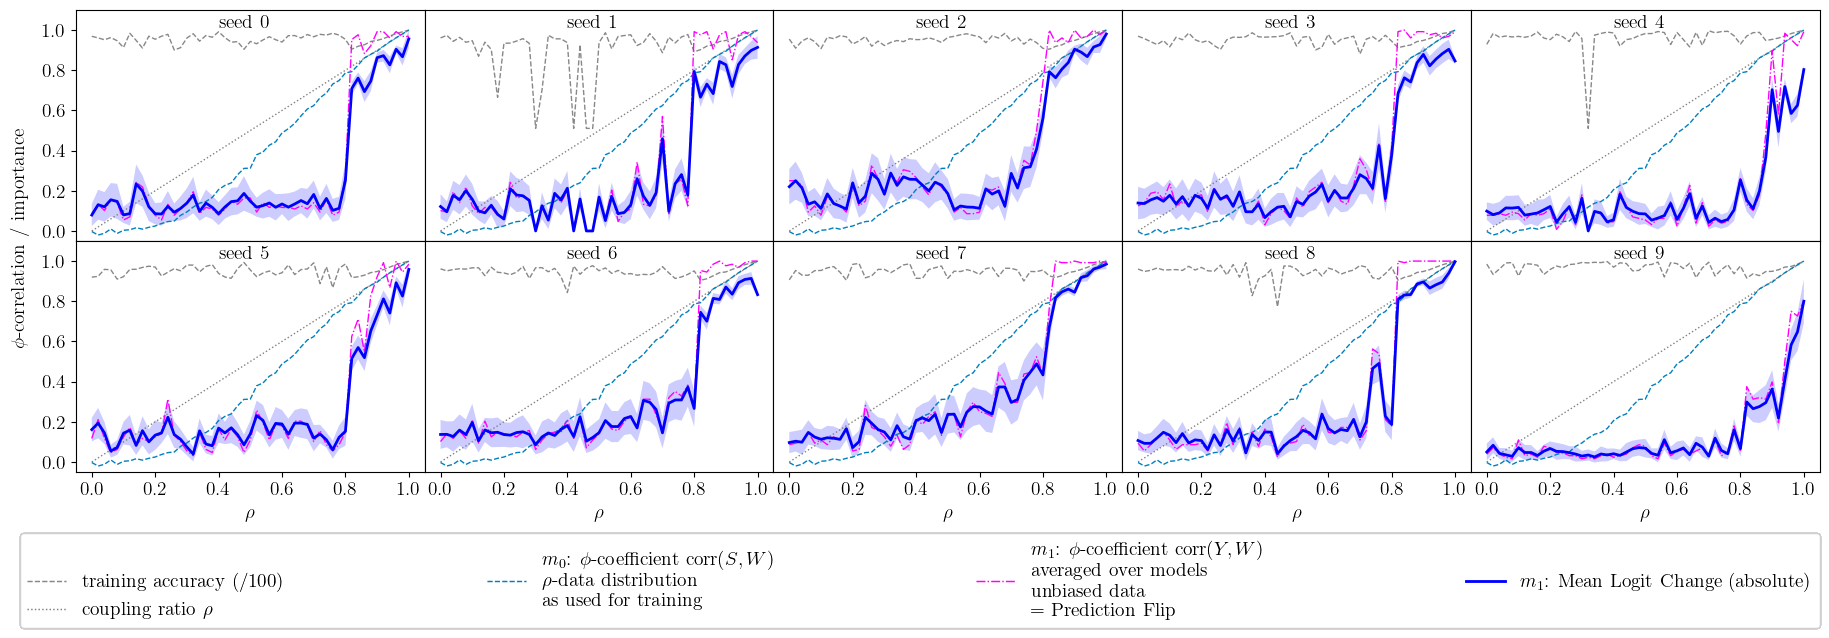

In [244]:
# MI and PHI over seeds

with open(accuracypath, "r") as jf:
    accuracies = json.load(jf)

with open(f"m0_gt_6400_{experiment_name}.pickle", "rb") as f:  # gt_measures_1280
    gt_measures = pickle.load(f)


ecol = matplotlib.cm.winter(np.linspace(0, 1, 5))
scol = matplotlib.cm.spring(np.linspace(0, 1, 5))


def to_name(b, i):
    return "b{}-i{}".format(
        str(round(b, 2)).replace(".", "_"),
        str(i),
    )


r, c = 2, 5

if iterations == 16:
    r, c = 4, 4


def axs_ind(s):
    return (s // c, s % c)
    


biases = list(np.round(np.linspace(0, 1, 51), 3))
fig, axs = plt.subplots(
    r,
    c,
    figsize=(
        c * 4.5,
        r * 3,
    ),
    gridspec_kw={"wspace": 0.0, "hspace": 0},
)

fig.text(
    0.1,
    0.5,
    "$\\phi$-correlation / importance",
    ha="center",
    va="center",
    rotation="vertical",
)
for s in range(iterations):
    names = [to_name(b, s) for b in biases]
    accuracy = np.array([accuracies[n]["train_accuracy"][2] / 100 for n in names])
    axs[axs_ind(s)].set_ylim([-0.05, 1.1])
    axs[axs_ind(s)].set_xlabel("$\\rho$")
    # axs[axs_ind(s)].set_ylabel("$\\phi$-correlation / importance")
    axs[axs_ind(s)].xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[axs_ind(s)].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    if (s // c) % r != 1:
        axs[axs_ind(s)].xaxis.set_visible(False)
    if s % c != 0:
        axs[axs_ind(s)].yaxis.set_visible(False)
    axs[axs_ind(s)].text(
        0.4,
        1.01,
        f"seed {s}",
        size=14,
    )
    axs[axs_ind(s)].plot(
        biases,
        accuracy,
        linewidth=1,
        linestyle="dashed",
        label="training accuracy (/100)" if s == 0 else "",
        color="#888",
    )
    axs[axs_ind(s)].plot(
        biases,
        biases,
        linewidth=1,
        label="coupling ratio $\\rho$" if s == 0 else "",
        linestyle="dotted",
        color="gray",
    )
    axs[axs_ind(s)].plot(
        biases,
        torch.mean(gt_measures[:, :, 2], dim=1),
        linewidth=1,
        label=(
            "$m_0$: $\\phi$-coefficient corr($S,W$) \n $\\rho$-data distribution \n as used for training"
            if s == 0
            else ""
        ),
        linestyle="dashed",
        color=ecol[2],
    )

    """ sma = torch.nn.AvgPool1d(kernel_size=5, stride = 1, padding=2, count_include_pad=False)
    shape_avg = sma(shape_gt[:, s, 1].view(1,1,51))
    axs[axs_ind(s)].plot(
        biases,
        shape_avg[0,0,:],
        linestyle=":",
        linewidth=2,
        label="shape $\\phi$-coefficient corr($Y,S$)  \n averaged over models \n unbiased data",
        color=ecol[3],#"#f00"#
    ) """
    m1_mlc = torch.mean(per_sample[:, s, :, 1], dim=1)
    m1_mlc_sigma = torch.std(per_sample[:, s, :, 1], dim=1) / math.sqrt(iterations)

    axs[axs_ind(s)].fill_between(
        biases,
        m1_mlc + m1_mlc_sigma,
        m1_mlc - m1_mlc_sigma,
        facecolor=ecol[0], #"#C8D672",#
        alpha=0.2,
    )

    m1_phi = torch.mean(per_sample[:, s, :, 0], dim=1)
    axs[axs_ind(s)].plot(
        biases,
        m1_phi,
        linewidth=1,
        linestyle="dashdot",
        label=(
            "$m_1$: $\\phi$-coefficient corr($Y,W$)  \n averaged over models \n unbiased data \n = Prediction Flip"
            if s == 0
            else ""
        ),
        color=scol[0],
    )
    axs[axs_ind(s)].plot(
        biases,
        m1_mlc,
        linewidth=2,
        label="$m_1$: Mean Logit Change (absolute)" if s == 0 else "",
        color=ecol[0],#"#C8D672"#
    )
    fig.legend(
        bbox_to_anchor=(0.1, -0.15 if iterations == 10 else 0.0, 0.8, 0.102),
        loc="lower left",
        ncols=4,
        mode="expand",
        borderaxespad=0.0,
    )

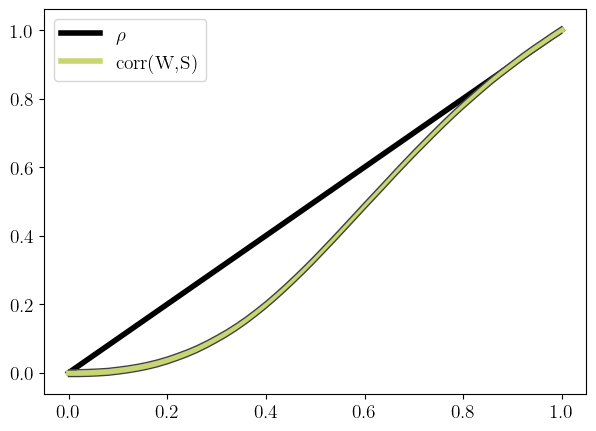

In [237]:
fig = plt.figure(figsize=(7, 5))
fig.set_facecolor("#fff")
fig.set_alpha(0.0)
ax = fig.add_subplot(111)
ax.set_facecolor("#fff")
ax.set_alpha(0.0)
plt.plot(BIASES, BIASES, color="#000", label="$\\rho$", linewidth=4)
plt.plot(BIASES, watermark_flip_m0, color="#C8D672", label="corr(W,S)", linewidth=4)
plt.plot(BIASES, watermark_flip_m0 -0.01, color="#404040", linewidth=1)
plt.plot(BIASES, watermark_flip_m0 +0.01, color="#404040", linewidth=1)
plt.legend(loc="upper left")

In [29]:
# FILTER BAD OUT
def filter_bad_out(data):
    filtered = torch.zeros(51,12,128,17)
    c = 0
    for num_it in range(iterations):
        if num_it not in [6,14, 1,3,]: #1,3,
            filtered[:, c] = data[:,num_it,:,:]
            c+=1
    return filtered
#filtered = filter_bad_out(per_sample)

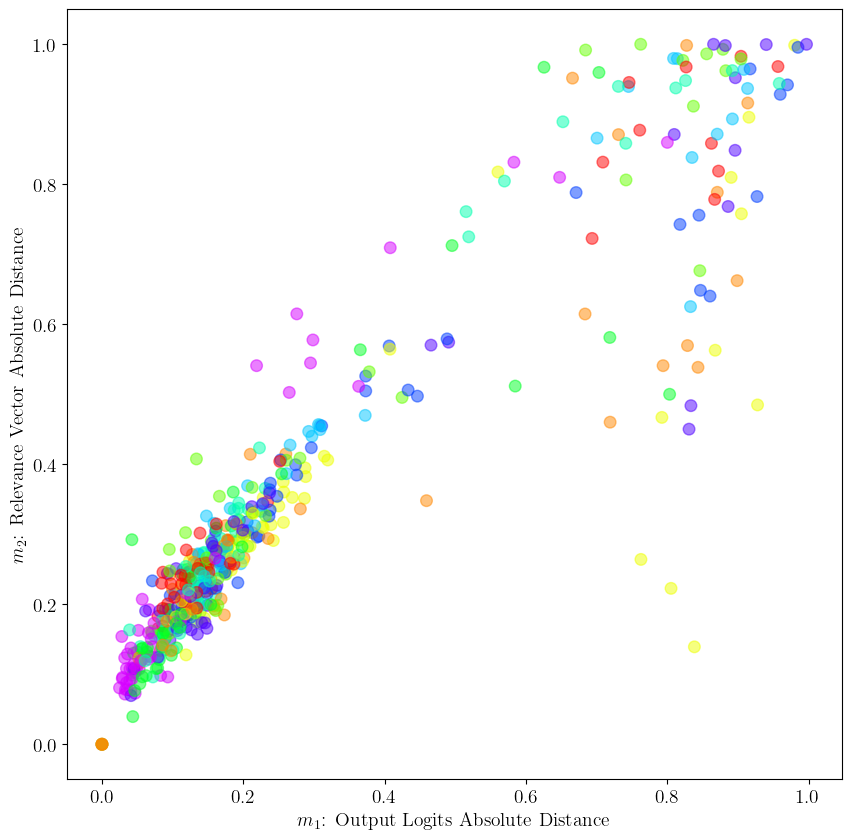

In [45]:
def compare_two_measures(per_sample, a, b):
    m1 = ALL_MEASURES.index(a)
    m1_label = NAME_DICT[a]
    m2 = ALL_MEASURES.index(b)
    m2_label = NAME_DICT[b]
    m1_val = per_sample[:,:,:,m1].mean(dim=(2)).flatten() #.flatten() #
    m2_val = per_sample[:,:,:,m2].mean(dim=(2)).flatten() #.flatten() #
    c0 = matplotlib.cm.hsv(
        np.linspace(0, 1, iterations +2)
    )
    c1 = matplotlib.cm.hsv(
        np.linspace(0, 1, iterations +2)
    )
    cols = [c0[i] if i % 2 == 0 else c1[i] for r in range(51) for i in range(iterations)]
    import matplotlib.patches as mpatches 
    cleg = [mpatches.Patch(color=cols[i], label=str(i)) for i in range(iterations) ]
    plt.figure(figsize=(10,10))
    plt.ylabel(m2_label)
    plt.xlabel(m1_label)
    plt.scatter(m1_val, m2_val, label=f"{m1_label} vs. {m2_label}",color=cols, alpha=0.5, s=70)
    #plt.legend(handles=cleg)
    
compare_two_measures(per_sample, "m1_mlc_abs", "m2_rel_abs")


#"m1_phi",
#"m1_mlc_abs",
#"m1_mlc_euclid",
#"m1_mlc_l2square",
#"m1_mlc_cosine",
#"m2_rel_abs",
#"m2_rel_cosine",
#"m2_rel_euclid",
#"m2_rel_l2square",
#"m2_mac_abs",
#"m2_mac_euclid",
#"m2_mac_cosine",
#"m2_mac_l2square",
#"m2_rma",
#"m2_bbox_rel",
#"m2_rra_weighted",
#"m2_pg_weighted",

torch.Size([51, 10, 39]) torch.Size([51, 39])


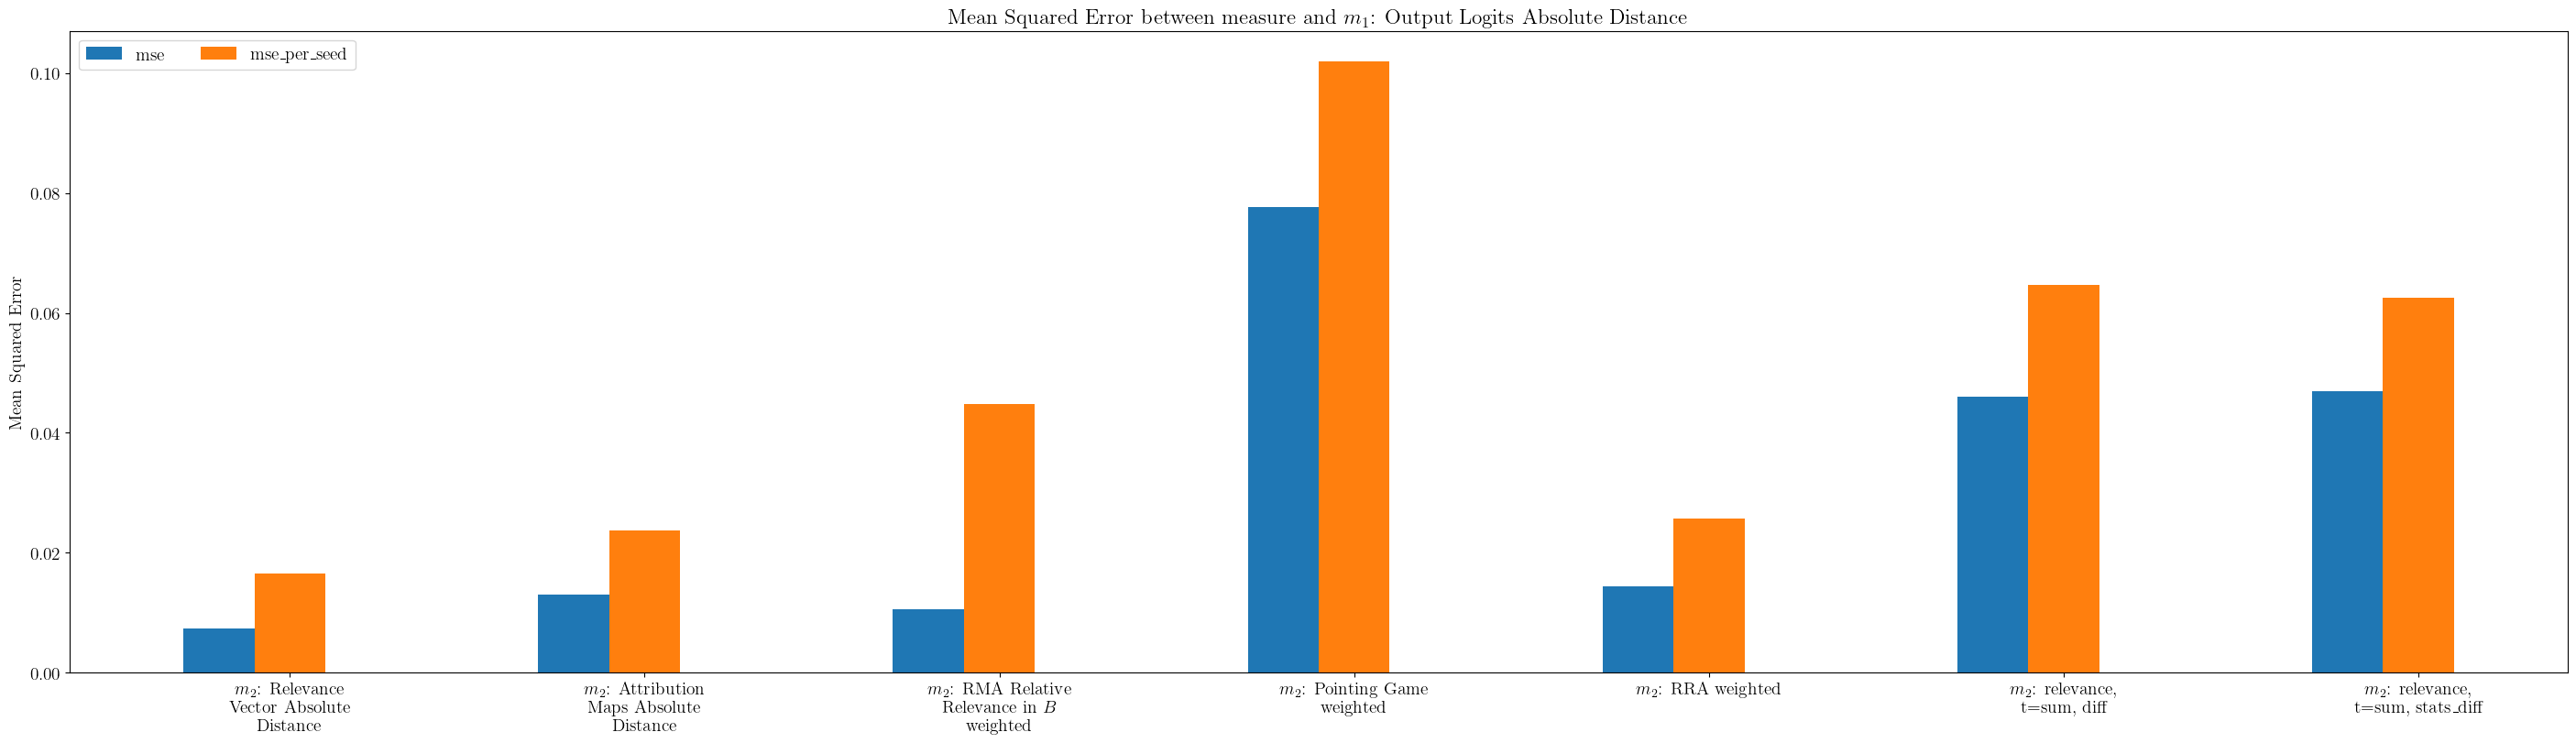

In [238]:
from textwrap import wrap

biases = list(np.round(np.linspace(0, 1, 51), 3))
weights = torch.nn.functional.softmax(torch.tensor(biases), dim=0)
m1s = [
    "m1_phi",
    "m1_mlc_abs",
    # "m1_mlc_euclid",
    #"m1_mlc_l2square",
    #"m1_mlc_cosine",
]

m2s = [
    "m2_rel_abs",
    #"m2_rel_cosine",
    #"m2_rel_euclid",
    #"m2_rel_l2square",
    "m2_mac_abs",
    #"m2_mac_euclid",
    #"m2_mac_cosine",
    #"m2_mac_l2square",
    "m2_rma",
    #"m2_rma_unweighted",
    "m2_pg_weighted",
    #"m2_pg_unweighted",
    "m2_rra_weighted",
    #"m2_rra_unweighted",
    #"m2_Rel_max_diff",
    #"m2_Rel_max_m_rels",
    #"m2_Rel_max_stats",
    #"m2_Rel_max_stats_diff",
    #"m2_Act_max_diff",
    #"m2_Act_max_m_rels",
    #"m2_Act_max_stats",
    #"m2_Act_max_stats_diff",
    "m2_Rel_sum_diff",
    #"m2_Rel_sum_m_rels",
    #"m2_Rel_sum_stats",
    "m2_Rel_sum_stats_diff",
    #"m2_Act_sum_diff",
    #"m2_Act_sum_m_rels",
    #"m2_Act_sum_stats",
    #"m2_Act_sum_stats_diff",
]


def mse(a, b):
    # return torch.nn.functional.mse_loss(a,b)
    return float(torch.mean(torch.square(a - b)))


def weighted_mse(a, b):
    if a.shape == (51, iterations):
        return torch.sum(torch.square((a - b)) * weights[:, None]) / iterations
    return torch.sum(torch.square((a - b)) * weights)  # torch.tensor(biases)


def r2_value(a, b):
    corr_matrix = np.corrcoef(a, b)  # actual, predict
    corr = corr_matrix[0, 1]
    R_sq = corr**2
    if np.isnan(R_sq):
        R_sq = 0.0
    return R_sq


mses = {}
for_plot = {
    "mse": [],
    "weighted_mse": [],
    "r2": [],
    "r2_per_seed": [],
    "mse_per_seed": [],
    "weighted_mse_per_seed": [],
}
per_rho = torch.mean(perseed_all, dim=(1))  # filtered
per_seed = perseed_all
print(per_seed.shape, per_rho.shape)
m1_index = 1
m1_phi_vals = per_rho[:, m1_index]
m1_phi_valsps = per_seed[:, :, m1_index]
for measure in m2s:
    mk = ALL_MEASURES.index(measure)
    vals = per_rho[:, mk]  # / per_rho[:, mk].max()

    if measure == "m2_mac_l2square":
        vals = vals / perseed_all[:, :, mk].max()
    if measure == "m2_mac_euclid":
        vals = vals / perseed_all[:, :, mk].max()

    mses[measure] = {
        "mse": mse(m1_phi_vals, vals),
        "weighted_mse": weighted_mse(m1_phi_vals, vals),
        "r2": r2_value(m1_phi_vals, vals),
        "r2_per_seed": r2_value(m1_phi_valsps.flatten(), per_seed[:, :, mk].flatten()),
        # torch.mean(torch.tensor([r2_value(m1_phi_valsps[:,s], per_seed[:, s, mk]) for s in range(16)])),
        "mse_per_seed": mse(m1_phi_valsps, per_seed[:, :, mk]),
        "weighted_mse_per_seed": weighted_mse(m1_phi_valsps, per_seed[:, :, mk]),
    }
    for_plot["mse"].append(mses[measure]["mse"])
    for_plot["weighted_mse"].append(mses[measure]["weighted_mse"])
    for_plot["r2"].append(mses[measure]["r2"])
    for_plot["r2_per_seed"].append(mses[measure]["r2_per_seed"])
    for_plot["mse_per_seed"].append(mses[measure]["mse_per_seed"])
    for_plot["weighted_mse_per_seed"].append(mses[measure]["weighted_mse_per_seed"])


x = np.arange(len(mses.keys()))  # the label locations
fig, ax = plt.subplots(layout="constrained", figsize=(28, 8))
width = 0.2  # the width of the bars
multiplier = 0
for attribute in ["mse", "mse_per_seed"]:  # , "weighted_mse", "weighted_mse_per_seed"
    measurement = for_plot[attribute]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    f"Mean Squared Error between measure and {NAME_DICT[ALL_MEASURES[m1_index]]}"
)
ax.set_ylabel("Mean Squared Error")
# ax.set_ylim([0.0, 0.016])
ax.set_xticks(x + width, ["\n".join(wrap(NAME_DICT[k], 20)) for k in mses.keys()])
ax.legend(loc="upper left", ncols=4)
# ax.set_ylim(0, 1)

' fig.legend(\n    handles=cleg,\n    bbox_to_anchor=(0.122, -0.24, 1.0, 0.102),\n    loc="lower left",\n    ncols=19,\n    borderaxespad=0.0,\n) '

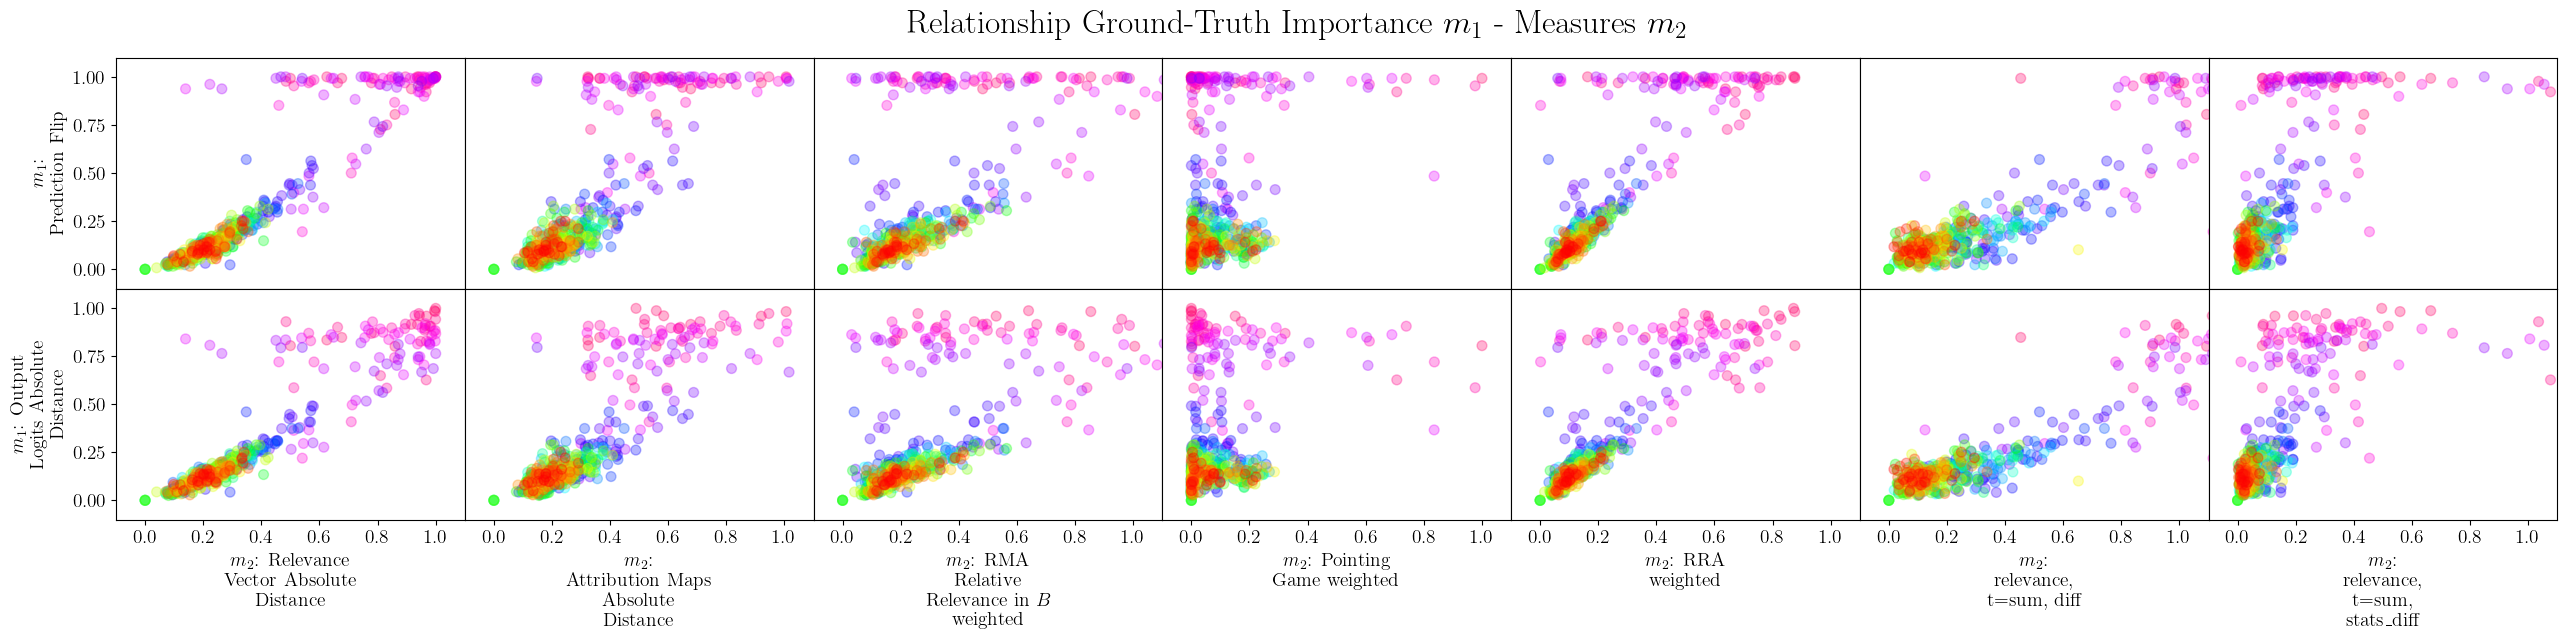

In [239]:
import matplotlib.patches as mpatches

r = len(m1s)
c = len(m2s)
fig, axs = plt.subplots(
    r,
    c,
    figsize=(
        c * 4.5,
        r * 3,
    ),
    gridspec_kw={"wspace": 0.0, "hspace": 0.0},
)
fig.suptitle("Relationship Ground-Truth Importance $m_1$ - Measures $m_2$",x=0.5, y=0.96, size=24 )

for m1i, m1 in enumerate(m1s):
    for m2i, m2 in enumerate(m2s):
        m1_index = ALL_MEASURES.index(m1)
        m1_label = NAME_DICT[m1]
        m2_index = ALL_MEASURES.index(m2)
        m2_label = NAME_DICT[m2]
        m1_val = perseed_all[:, :, m1_index].flatten()  # .flatten() #
        m2_val = perseed_all[:, :, m2_index].flatten()  # .flatten() #
        if m2 == "m2_mac_l2square":
            m2_val = m2_val / perseed_all[:, :,m2_index].max() 
        if m2 == "m2_mac_euclid":
            m2_val = m2_val / perseed_all[:, :,m2_index].max() 
        axs[m1i, m2i].set_ylim([-0.1, 1.1])
        axs[m1i, m2i].set_xlim([-0.1, 1.1])
        axs[m1i, m2i].set_xlabel("\n".join(wrap(m2_label, 16)))
        axs[m1i, m2i].set_ylabel("\n".join(wrap(m1_label, 16)))
        axs[m1i, m2i].xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #axs[m1i, m2i].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        if m2i > 0:
            axs[m1i, m2i].yaxis.set_visible(False)
        plot_idx = list(range((iterations*51 -1),-1,-1))#np.random.permutation(m1_val.shape[0])
        colorvals = matplotlib.cm.hsv(np.linspace(0, 1, 54))
        cols = [colorvals[r] for r in range(51) for i in range(iterations)]
        cleg = [mpatches.Patch(color=colorvals[i], label=str(biases[i])) for i in range(51)]
        color_seq = torch.tensor(cols)[plot_idx]
        axs[m1i, m2i].scatter(m2_val[plot_idx], m1_val[plot_idx], c=color_seq, alpha=0.3, s=50)  # color="black",
""" fig.legend(
    handles=cleg,
    bbox_to_anchor=(0.122, -0.24, 1.0, 0.102),
    loc="lower left",
    ncols=19,
    borderaxespad=0.0,
) """

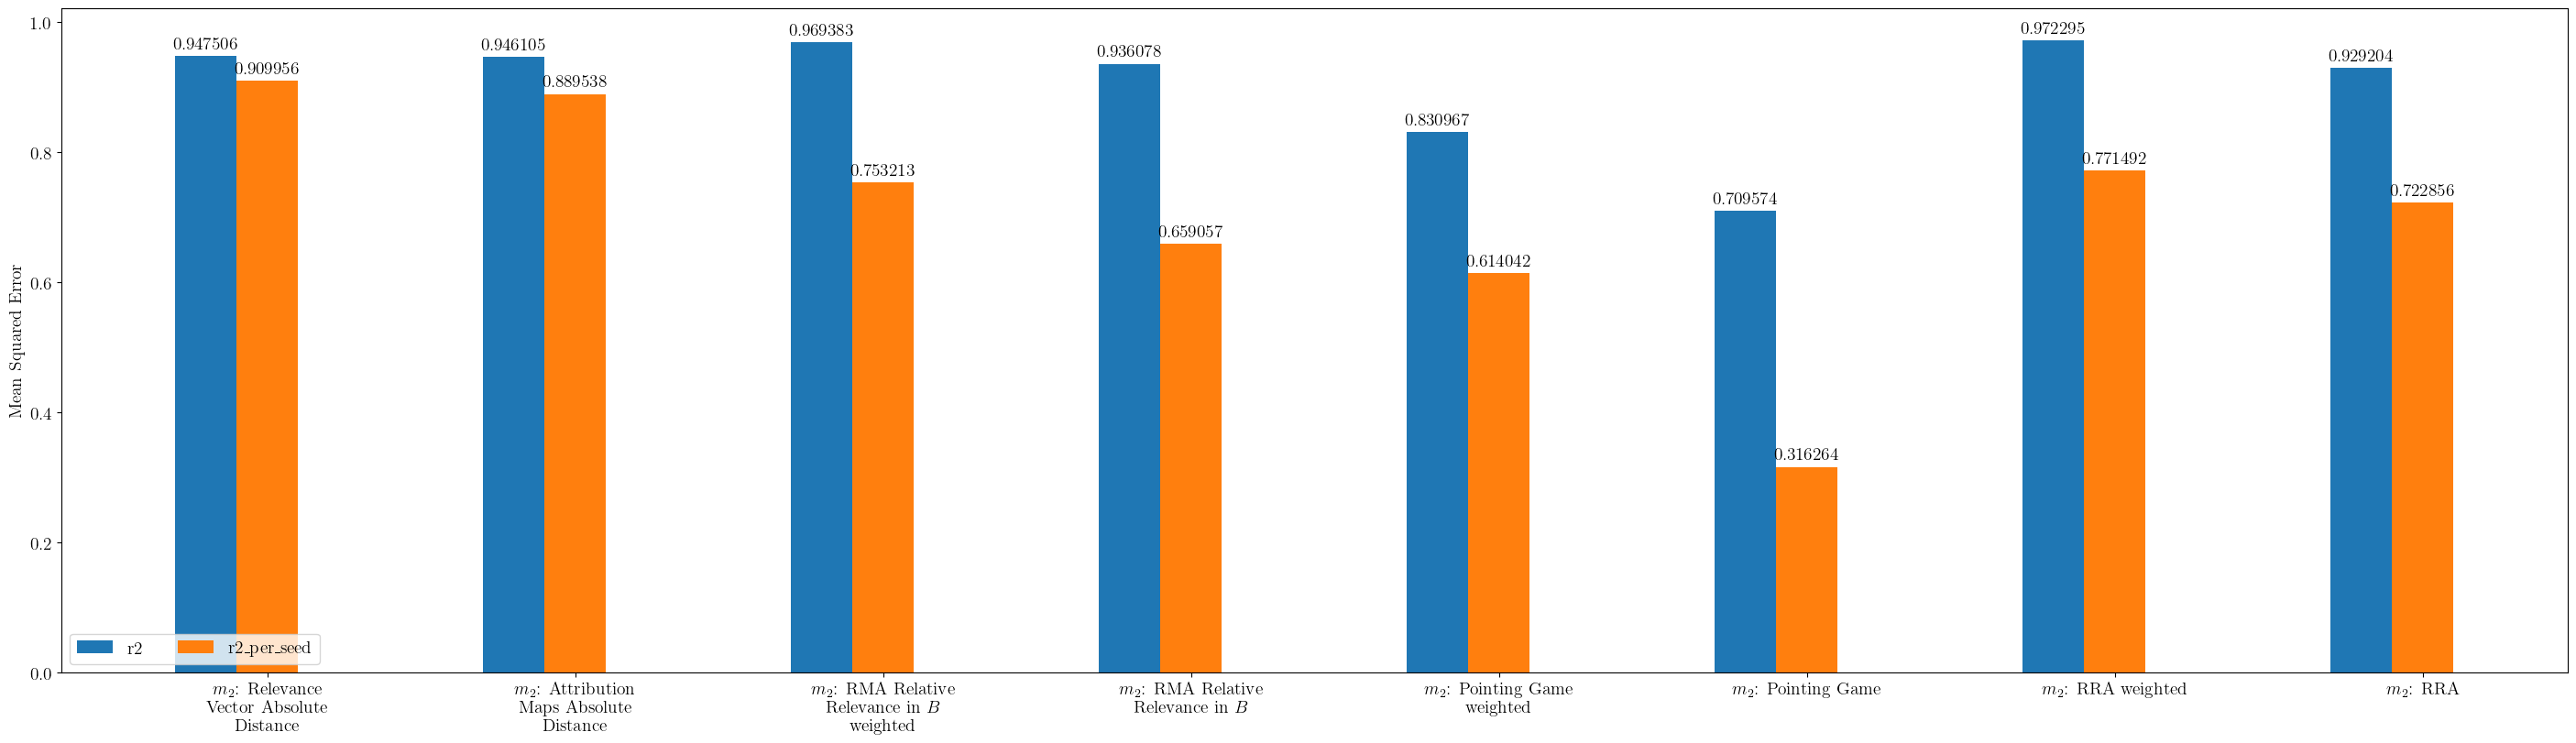

In [27]:

x = np.arange(len(mses.keys()))  # the label locations
fig, ax = plt.subplots(layout="constrained", figsize=(28, 8))
width = 0.2  # the width of the bars
multiplier = 0
for attribute in ["r2", "r2_per_seed"]:
    measurement = for_plot[attribute]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(x + width, ["\n".join(wrap(NAME_DICT[k], 20)) for k in mses.keys()])
ax.legend(loc="lower left", ncols=3)
# ax.set_ylim(0, 1)

/tmp/ipykernel_1473472/1004671826.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


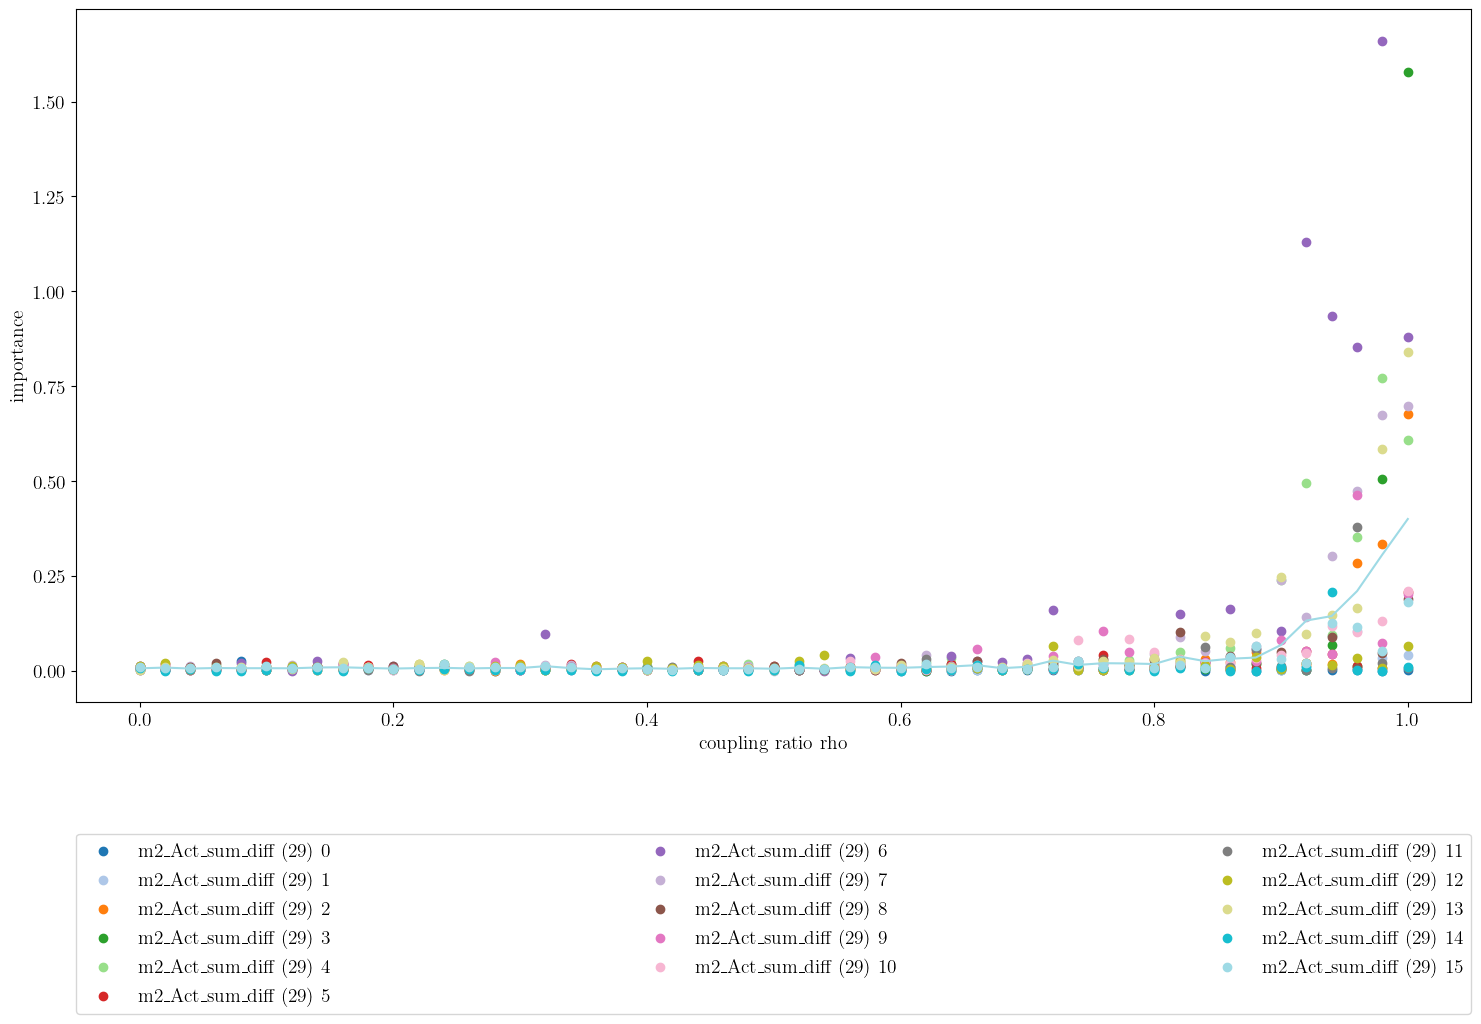

In [320]:
# MEASURES OVER SINGLE SEEDS

biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = [29]#,12,16,18, 20] #range(len(ALL_MEASURES))
ls = ["dotted", "dashed", "solid"]

#colors = matplotlib.cm.tab20(np.linspace(0, 1, len(takeing)))
colors = matplotlib.cm.tab20(np.linspace(0, 1, iterations))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    plt.plot(
                biases,
                torch.mean(perseed_all[:,:, i],dim=1),
                linestyle=ls[int(l[1])],
                c=colors[num],
            )  
    for num in range(iterations):
        l = ALL_MEASURES[i]
        label = f"{l} ({i}) {num}"
        vals = perseed_all[:,num, i] 
        if  l: #.startswith("m2_mac")
            plt.scatter(
                biases,
                vals,
                label=label,
                linestyle=ls[int(l[1])],
                c=colors[num],
            )  

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.45, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)
